In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pyarrow.parquet as pq
from numpy.linalg import norm
import random
import time
from sklearn.svm import SVR

In [2]:
train_df = pd.read_parquet("C:/Users/jdegu/Documents/cours/M2_IA/apprentissage_supervise/Data_challenge/NYC_taxis_tips/" \
                        +"train.parquet")
test_df = pd.read_parquet("C:/Users/jdegu/Documents/cours/M2_IA/apprentissage_supervise/Data_challenge/NYC_taxis_tips/" \
                        +"test.parquet")
naive_sub = pd.read_parquet("C:/Users/jdegu/Documents/cours/M2_IA/apprentissage_supervise/Data_challenge/NYC_taxis_tips/" \
                        +"naive_submission.parquet")

In [3]:
X_train = train_df.drop(columns= ['tip_amount','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag']) 
X_test = test_df.drop(columns= ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag'])

Y_train = train_df['tip_amount']

X_train.head()

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,1,1.0,3.30,1.0,1,19.1,3.5,0.5,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635
1,2,1.0,0.72,1.0,1,5.8,2.5,0.5,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2,2.0,7.45,1.0,1,38.7,0.0,0.5,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012
3,2,1.0,1.53,1.0,1,10.0,1.0,0.5,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492
4,2,1.0,1.53,1.0,1,10.0,0.0,0.5,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492


In [4]:
def optimise_alpha(X, Y, Kernel, lbda=1):
    # On transforme nos DataFrame en matrices numpy
    if type(X) == pd.core.frame.DataFrame:
        X = X.to_numpy()
    if type(Y) == pd.core.frame.DataFrame:
        Y = Y.to_numpy()
        
    K = np.array([ [Kernel_gauss(x1,x2) for x2 in X] for x1 in X]) 
    n = len(X)
    alpha = np.linalg.inv(K + len(X)*lbda*np.eye(len(X)))@Y
    return alpha

In [5]:
def predicteur(Kernel, alpha, X_connu, x_predict):
    K_Xx = np.array([Kernel(x, x_predict) for x in X_connu])
    return alpha@K_Xx

def predicteur2(Kernel, alpha, X_connu, x_predict):
    return np.sum([alpha[i]*Kernel(X_connu[i], x_predict) for i in range(len(X_connu))])


# On selectionne k=1000 lignes de X_train pour l'entrainement

In [14]:
indices_selectionnes_train = random.choices(range(len(X_train)), k = 1000)
indices_selectionnes_test = random.choices(range(len(X_train)), k = 1000)
X_train_choice = X_train.to_numpy()[indices_selectionnes_train]
Y_train_choice = Y_train.to_numpy()[indices_selectionnes_train]
X_test_choice = X_train.to_numpy()[indices_selectionnes_test]
Y_test_choice = Y_train.to_numpy()[indices_selectionnes_test]

# Noyau Gaussien

In [28]:
var = np.var(Y_train_choice)
def Kernel_gauss(x1,x2, sigma2=var):
    return np.exp(-norm(x1-x2)**2/(2*sigma2))

for lbda in [0.00001,0.001,0.1,1,10,100]:
    alpha = optimise_alpha(X_train_choice, Y_train_choice, Kernel_gauss, lbda = lbda)
    Y_pred = [predicteur2(Kernel_gauss, alpha, X_train_choice, x_test) for x_test in X_test_choice]
    print(r2_score(Y_test_choice, Y_pred))

-0.2694081254936114
-0.17523593900215984
-0.3216365252333777
-0.6030068871323615
-0.7240112335717024
-0.7411976733877357


temps d'exécution  11.738182783126831 9 / 10


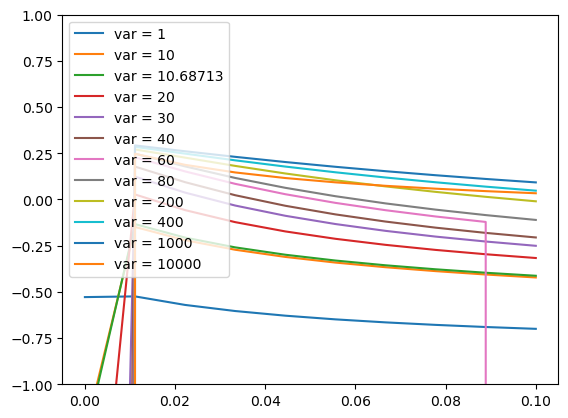

In [7]:
liste_var = [1,10,np.var(Y_train_choice), 20, 30, 40,60,80,200,400,1000,10000]
liste_lbda = [0.00001,0.0001,0.001,0.1,1,2]
liste_lbda = np.linspace(0,0.1,10) # liste_lbda est un tableau
tab_r2_lbda = np.zeros((len(liste_var), len(liste_lbda)))
start = time.time()

for i in range(len(liste_var)):
    var = liste_var[i]
    def Kernel_gauss(x1,x2, sigma2=var):
        return np.exp(-norm(x1-x2)**2/(2*sigma2))
    for j in range(len(liste_lbda)):
        lbda = liste_lbda[j]
        try :
            alpha = optimise_alpha(X_train_choice, Y_train_choice, Kernel_gauss, lbda = lbda)
            Y_pred = [predicteur2(Kernel_gauss, alpha, X_train_choice, x_test) for x_test in X_test_choice]
            tab_r2_lbda[i,j] = r2_score(Y_test_choice, Y_pred)
        except : 
            tab_r2_lbda[i,j] = -1000
        print(" dernier effectué : i = " + str(i) + " / " + str(len(liste_var)) + "   j = " + str(j) + " / " + str(len(liste_lbda)), end = '\r')
    plt.plot(liste_lbda,tab_r2_lbda[i,:], label = 'var = ' +str(var))
print("temps d'exécution  " + str(time.time() - start))
plt.legend()
plt.ylim([-1,1])
plt.xlabel("")
plt.show()

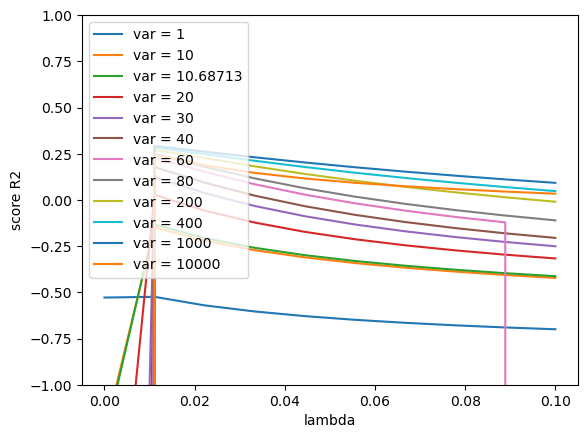

In [8]:
for i in range(len(liste_var)):
    plt.plot(liste_lbda,tab_r2_lbda[i,:], label = 'var = ' +str(liste_var[i]))
plt.legend()
plt.ylim([-1,1])
plt.xlabel("lambda")
plt.ylabel("score R2")
#plt.title('score R2 pour différentes valeurs de lambda et \sigma**2')
plt.show()

# Noyau Polynomial

temps d'exécution  24.163433074951172 8


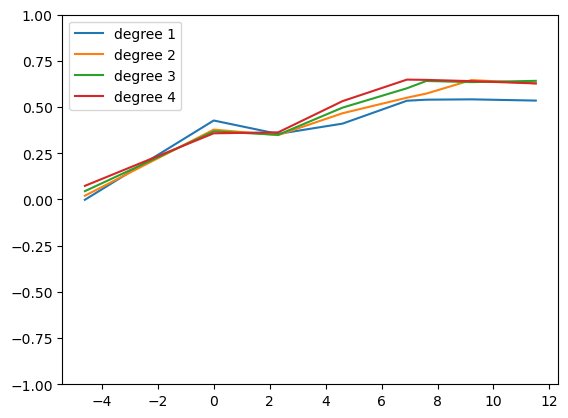

In [17]:
liste_C = [0.01,1,10,10**2,10**3,2*10**3,10**4,10**5]
liste_degree = [1,2,3,4]
tab_r2 = np.zeros((len(liste_degree),len(liste_C)))
start = time.time()
for i in range(len(liste_degree)):
    degree = liste_degree[i]
    for j in range(len(liste_C)):
        C = liste_C[j]
        svr_poly = SVR(kernel='poly', C=C, degree=degree)
        model = svr_poly.fit(X_train_choice,Y_train_choice)
        Y_pred = model.predict(X_test_choice)
        tab_r2[i,j] = r2_score(Y_test_choice, Y_pred)
        print(" dernier effectué : i = " + str(i) + " / " + str(len(liste_degree)) + " j = " + str(j) + " / " + str(len(liste_C)), end = '\r')      
    plt.plot(np.log(liste_C), tab_r2[i,:], label = 'degree ' + str(degree) )
print("temps d'exécution  " + str(time.time() - start))
plt.legend()
plt.ylim([-1,1])
plt.show()

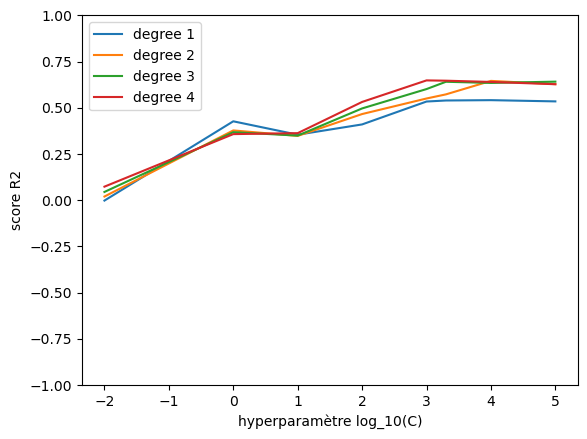

In [19]:
for i in range(len(liste_degree)):
    plt.plot(np.log10(liste_C),tab_r2[i,:], label = 'degree ' +str(liste_degree[i]))
plt.legend()
plt.ylim([-1,1])
plt.xlabel("hyperparamètre log_10(C)")
plt.ylabel("score R2")
plt.show()

# Prediction avec Noyau Gaussien

In [49]:
indices_selectionnes_train = random.choices(range(len(X_train)), k = 2000)
X_train_reduit = X_train.to_numpy()[indices_selectionnes_train]
Y_train_reduit = Y_train.to_numpy()[indices_selectionnes_train]

In [50]:
var = 10000
lbda = 0.02
def Kernel_gauss(x1,x2, sigma2=var):
        return np.exp(-norm(x1-x2)**2/(2*sigma2))

In [51]:
start = time.time()
alpha = optimise_alpha(X_train_reduit, Y_train_reduit, Kernel_gauss, lbda = lbda)
print("temps d'exécution  " + str(time.time() - start))
# 16 sec pour k = 2000
# > 2h pour X_train entier

temps d'exécution  16.566585779190063


In [32]:
start = time.time()
Y_pred = [predicteur2(Kernel_gauss, alpha, X_train_reduit, x_test) for x_test in X_test.to_numpy()[:100000]]
print("temps d'exécution  " + str(time.time() - start))
# 1050 sec pour k = 100

temps d'exécution  43.45327806472778


In [33]:
prediction_2_bon_format = pd.DataFrame(np.arange(len(Y_pred), dtype = int).T, columns  = ["row_ID"])
prediction_2_bon_format["tip_amount"] = Y_pred
prediction_2_bon_format.to_parquet("C:/Users/jdegu/Documents/cours/M2_IA/apprentissage_supervise/Data_challenge/NYC_taxis_tips/predictions/prediction_noyau_gauss.parquet")

In [34]:
print(Y_pred[:5])

[2.705607647294717, 2.967545105249714, 2.753765384556522, 2.7637479992072937, 2.7373132516941605]


# Prediction avec Noyau Polynomial de degré 2, C = 1000

In [6]:
indices_selectionnes_train = random.choices(range(len(X_train)), k = 10000)
X_train_reduit = X_train.to_numpy()[indices_selectionnes_train]
Y_train_reduit = Y_train.to_numpy()[indices_selectionnes_train]

# X_train_reduit = X_train.to_numpy()
# Y_train_reduit = Y_train.to_numpy()

In [7]:
C = 1000
degree = 2
start = time.time()
svr_poly = SVR(kernel='poly', C=C, degree=degree)
model = svr_poly.fit(X_train_reduit,Y_train_reduit)
Y_pred = model.predict(X_test.to_numpy())
print("temps d'exécution  " + str(time.time() - start))
# 32 sec pour k = 1000
# 300 sec pour k = 10 000
# 3700 sec pour X_train entier

temps d'exécution  312.36543226242065


In [8]:
prediction_SVRdegree2 = pd.DataFrame(np.arange(len(Y_pred), dtype = int).T, columns  = ["row_ID"])
prediction_SVRdegree2["tip_amount"] = Y_pred
prediction_SVRdegree2.to_parquet("C:/Users/jdegu/Documents/cours/M2_IA/apprentissage_supervise/Data_challenge/NYC_taxis_tips/predictions/prediction_SVRdegree2.parquet")